In [1]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings

In [2]:
#            Psurf/kbar         Msurf/Me            Rsurf/Re
structure = [55.7995885204057   1.87357329869088    1.26545448273556
             94.9872390766408   1.85080181213859    1.18895003698611
             235.441189355888   1.81201269545852    1.03160242765241
             44.0805809467927   1.8874745283649     1.26809523799334
             81.3022504424403   1.86358543333935    1.19126026978588
             215.825183545351   1.82258865495902    1.03329680311623
             36.606020371988    1.89635484051907    1.26977486802543
             72.7858858655158   1.87155246958974    1.19269414869405
             203.510277091369   1.82923648889318    1.03435826758376]
nsamps = size(structure)[1]

9

In [3]:
# Import AGNI
ROOT_DIR = abspath(joinpath(pwd(),"../"))
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.solver as nl
import AGNI.setpt as setpt
import AGNI.dump as dump
import AGNI.plotting as plotting

# Disable logging from AGNI module
AGNI.setup_logging("",1)

In [4]:
R_earth = 6.371e6
M_earth = 5.972e24

5.972e24

In [5]:
# Configuration options
instellation    = 81690.0
mass            = 1.8*M_earth
radius          = 1.2*R_earth
gravity         = 6.67e-11 * mass / radius^2
p_surf          = 2e4

s0_fact         = 0.25
zenith_degrees  = 54.74
albedo_b        = 0.0
nlev_centre     = 50
p_top           = 1e-5      # bar
mole_fractions  = Dict([
                        ("H2S", 0.23988329190194904),
                        ("SO2", 0.0044668359215096305),
                        ("N2" , 5.623413251903491e-6),
                        ("H2" , 0.7093907341517219)
                    ])
tmp_surf        = 3000.0
thermo          = true

albedo_data   = joinpath(ROOT_DIR,"res/surface_albedos/lunar_marebasalt.dat")
spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Honeyside/256/Honeyside.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/l-98-59.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

"/home/n/nichollsh/AGNI/out/"

In [6]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

In [7]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, s0_fact, albedo_b, zenith_degrees,
                        tmp_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",

                        tmp_int = 0.0,
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        thermo_functions=thermo,
                        surface_material=albedo_data
                    )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Composition set by dict 
[ INFO  ] Found FastChem executable 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocated atmosphere with composition: 
[ INFO  ]       1 H2      7.44e-01  
[ INFO  ]       2 H2S     2.52e-01  
[ INFO  ]       3 SO2     4.68e-03  
[ INFO  ]       4 N2      5.90e-06  


true

In [8]:
setpt.loglinear!(atmos, 700.0)

In [9]:
solver_success = nl.solve_energy!(atmos,
                                    sol_type=1,
                                    sens_heat=true,
                                    latent=true,
                                    method=1,
                                    dx_max=600.0,
                                    ls_method=1 ,
                                    save_frames=false, modplot=1,
                                    conv_atol=0.5,
                                    modprint=1
                                    )
println("Solver success? $solver_success")
atm_base = deepcopy(atmos);

[ INFO  ]     sol_type = 1 
[ INFO  ]     tmp_surf = 3000.00 K 
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags 
[ INFO  ]        1  -1.21e+03  1.250e+04  7.778e+04  3.000e+03  3.989e+02  C2-Nr-Ls 
[ INFO  ]        2  -3.36e+02  3.607e+03  3.128e+04  3.000e+03  3.093e+02  C2-Nr 
[ INFO  ]        3  -6.24e+01  9.809e+02  1.658e+04  3.000e+03  2.077e+02  C2-Nr 
[ INFO  ]        4  -2.91e-03  2.574e+02  1.293e+04  3.000e+03  8.449e+01  C2-Nr 
[ INFO  ]        5  +9.13e-04  2.423e+01  1.246e+04  3.000e+03  1.979e+01  C2-Nr 
[ INFO  ]        6  +7.14e-05  3.146e-01  1.245e+04  3.000e+03  2.271e+00  C2-Nr 
[ INFO  ]     success in 6 steps 
[ INFO  ]     outgoing LW flux   = +1.24e+04 W m-2      
[ INFO  ]     total flux at TOA  = +9.88e+02 W m-2      
[ INFO  ]     total flux at BOA  = +9.88e+02 W m-2      
[ INFO  ]     column max loss    = +2.67e-01 W m-2  (+2.70e-02 %)  
[ INFO  ]     final cost value   = +3.15e-01 W m-2      
[ INFO  ]     surf temperatu

In [10]:
atm_arr = atmosphere.Atmos_t[]

@printf("Running model for %d samples... \n", nsamps)

atmos = deepcopy(atm_base)
for i in 1:nsamps
    @printf("    sample %d/%d \n",i,nsamps)

    # update planet structure
    row = structure[i,:]
    Ps = row[1] * 1e3 * 1e5 # convert kbar -> bar -> Pa
    Ms = row[2] * M_earth
    Rs = row[3] * R_earth

    atmos.rp = Rs
    atmos.p_boa = Ps
    atmos.grav_surf = 6.67e-11 * Ms / Rs^2
    @printf("    Ps=%.1e Pa  ,  Ms=%.1e kg  ,  Rs=%.1e m \n",Ps,Ms,Rs)

    atmosphere.generate_pgrid!(atmos)

    # Run model
    solver_success = nl.solve_energy!(atmos,
                                    sol_type=3,
                                    sens_heat=true,
                                    latent=true,
                                    method=1,
                                    dx_max=400.0,        # Smaller steps
                                    ls_method=1 ,
                                    save_frames=false, modplot=0,
                                    modprint=1, perturb_all=false,
                                    conv_atol=0.1
                                    )

    # Store result
    push!(atm_arr, deepcopy(atmos))
    @printf("--------------------------------- \n")
end
println("Done!")

Running model for 9 samples... 
    sample 1/9 
    Ps=5.6e+09 Pa  ,  Ms=1.1e+25 kg  ,  Rs=8.1e+06 m 
[ INFO  ]     sol_type = 3 
[ INFO  ]     tmp_int  = 0.00 K 
[ INFO  ]     f_int    = 0.00 W m-2 
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags 
[ INFO  ]        1  +1.34e-01  1.268e+02  1.144e+04  2.631e+03  3.698e+02  C2-Nr-Ls 
[ INFO  ]        2  +1.02e-02  4.003e+01  1.146e+04  2.310e+03  3.209e+02  C2-Nr 
[ INFO  ]        3  -2.17e-03  1.589e+01  1.146e+04  2.058e+03  2.519e+02  C2-Nr 
[ INFO  ]        4  +1.43e-03  5.042e+00  1.146e+04  1.848e+03  2.104e+02  C2-Nr 
[ INFO  ]        5  +7.84e-04  4.596e+00  1.146e+04  1.830e+03  2.158e+01  C2-Nr-Ls 
[ INFO  ]        6  +5.74e-04  1.436e+00  1.146e+04  1.662e+03  1.679e+02  C2-Nr 
[ INFO  ]        7  +8.24e-04  7.043e-01  1.146e+04  1.546e+03  1.160e+02  C2-Nr 
[ INFO  ]        8  +1.82e-05  2.416e-01  1.146e+04  1.480e+03  6.584e+01  C2-Nr 
[ INFO  ]        9  +2.12e-06  1.757e-02  1.146e+04  1.

In [11]:
fs=12
lw=1.5

1.5

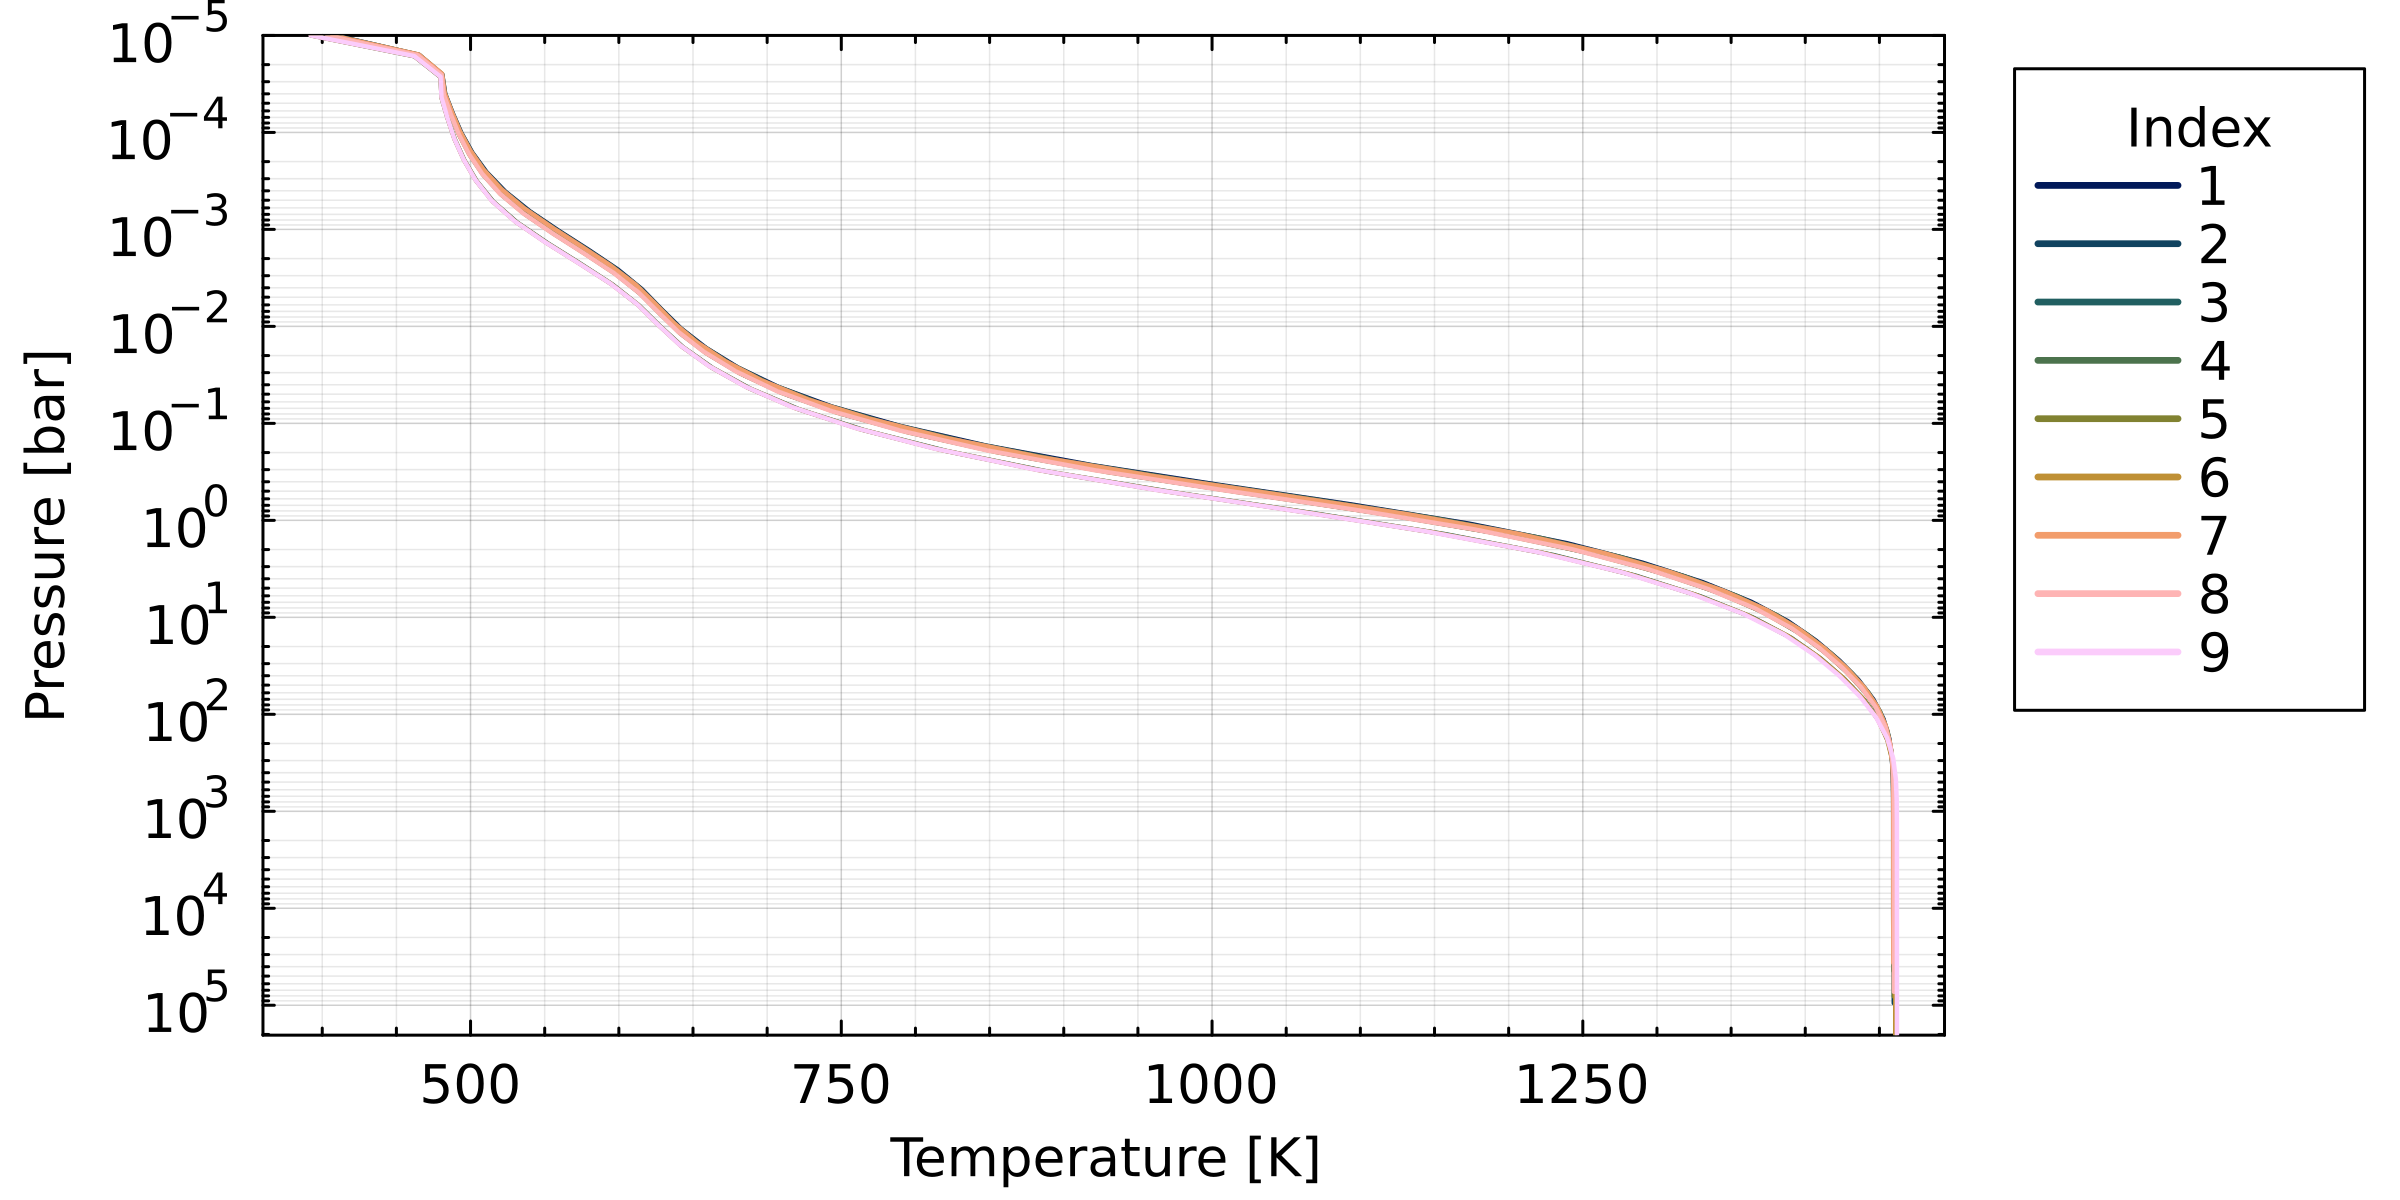

"/home/n/nichollsh/AGNI/out/profiles.pdf"

In [28]:
arr_P = atmos.pl .* 1.0e-5 # Convert Pa to bar
ylims  = (arr_P[1], arr_P[end])
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

plt = plot(framestyle=:box, size=(800,400), dpi=300,
                leg=:outertopright, legcolumn=-1,
                tickfontsize=fs, guidefontsize=fs, legendfontsize=fs,
                legendtitlefontsize=fs,
                leg_title="Index",
                left_margin=4Plots.mm, bottom_margin=4Plots.mm)


p = Plots.palette(:batlow, nsamps)
for i in 1:nsamps
    this_atm = atm_arr[i]
    plot!(plt, this_atm.tmpl, this_atm.pl* 1.0e-5, lc=p[i], linewidth=lw, label=@sprintf("%d",i))
end

xlabel!(plt, "Temperature [K]")
xaxis!(plt, minorgrid=true)
ylabel!(plt, "Pressure [bar]")
yflip!(plt)
yaxis!(plt, yscale=:log10, ylims=ylims, yticks=yticks)
display(plt)
savefig(plt,joinpath(output_dir,"profiles.pdf"))

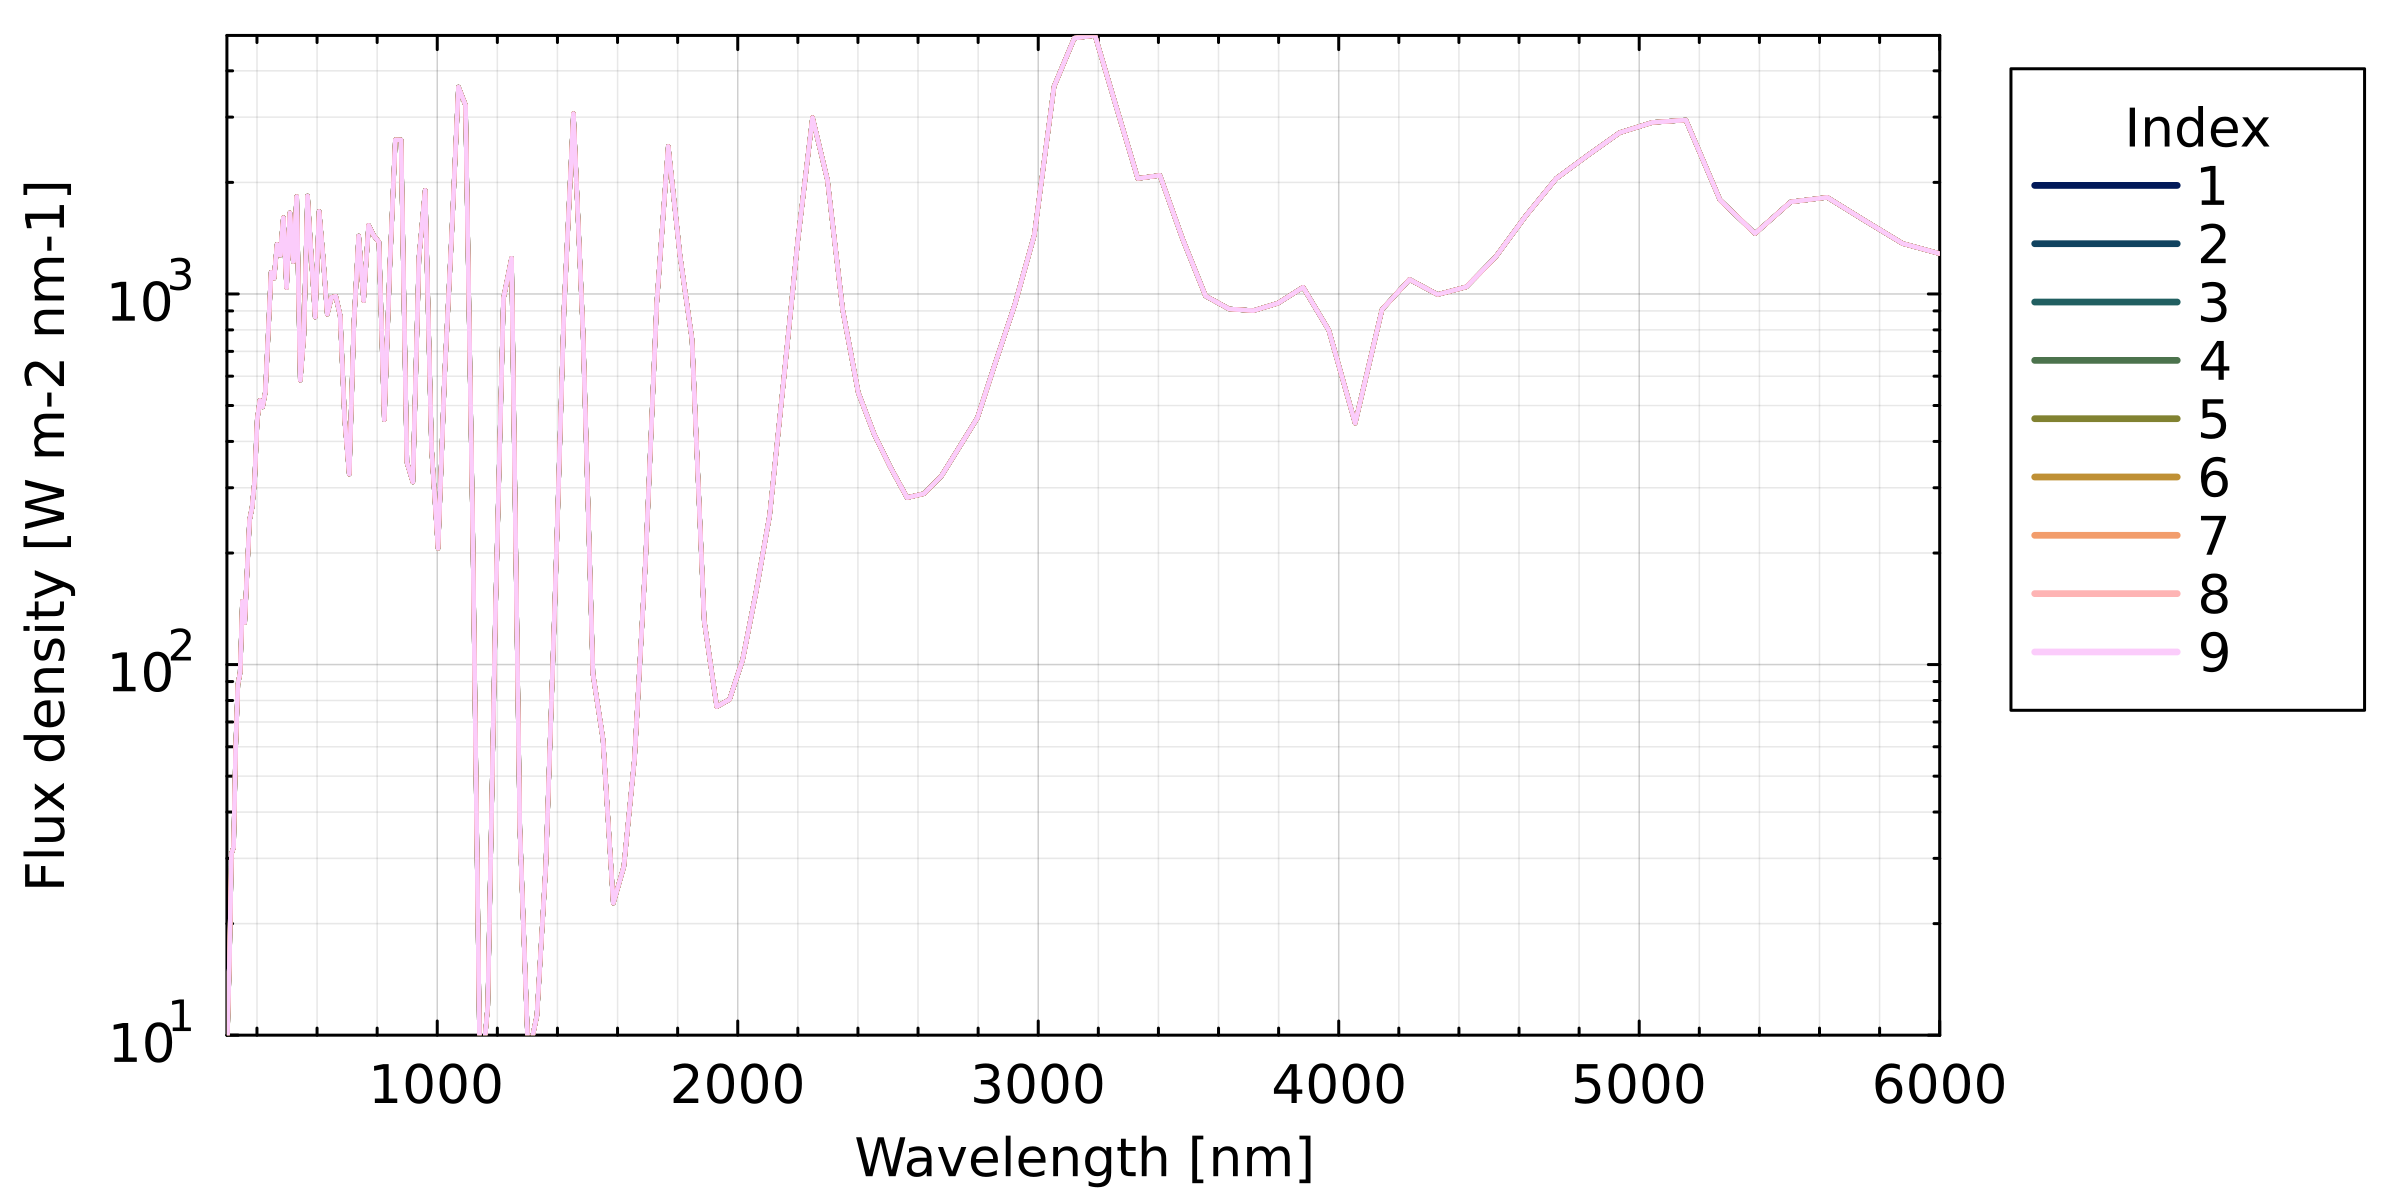

"/home/n/nichollsh/AGNI/out/emission.pdf"

In [26]:
plt = plot(framestyle=:box, size=(800,400), dpi=300,
                leg=:outertopright, legcolumn=-1,
                tickfontsize=fs, guidefontsize=fs, legendfontsize=fs,
                legendtitlefontsize=fs,
                leg_title="Index",
                left_margin=4Plots.mm, bottom_margin=4Plots.mm)

p = Plots.palette(:batlow, nsamps)
for i in 1:nsamps
    this_atm = atm_arr[i]


    # band widths
    wd = atmos.bands_wid * 1e9 # convert to nm

    # band centres
    xe = atmos.bands_cen * 1e9 # convert to nm

    # TOA upward spectral flux [erg s-1 cm-2 nm-1]
    yt = (atmos.band_u_sw[1, :] .+  atmos.band_u_lw[1, :]) .* 1000.0 ./ wd

    plot!(plt, xe, yt, lc=p[i], linewidth=lw, label=@sprintf("%d",i))
end

xlabel!(plt, "Wavelength [nm]")
xaxis!(plt, xscale=:lo010, minorgrid=true, xlims=(300.0, 6.0e3))

ylabel!(plt, "Flux density [W m-2 nm-1]")
yaxis!(plt, yscale=:log10, ylims=(10, Inf))

display(plt)
savefig(plt,joinpath(output_dir,"emission.pdf"))

In [13]:
for (i, atm) in enumerate(atm_arr)
    @printf("Writing index %d \n",i)
    dump.write_ncdf(atm, joinpath(atm.OUT_DIR, "$i.nc"))
end
@printf("Done \n")

Writing index 1 
Writing index 2 
Writing index 3 
Writing index 4 
Writing index 5 
Writing index 6 
Writing index 7 
Writing index 8 
Writing index 9 
Done 
